# <center>Градиентный бустинг для задачи классификации</center>

In [1]:
import numpy as np
from scipy.special import softmax

from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plt
%matplotlib inline

**Задание.** Используйте реализацию из предыдущего задания, чтобы адаптировать алгоритм градиентного бустинга для задачи классификации. Обратите внимание, что название класса в текущем файле было изменено.

- Реализуйте методы `sigmoid` и `softmax`, необходимые для обработки результатов предсказаний.
- Методы `log_loss_grad` и `cross_entropy_grad` должны возвращать градиенты функции потерь для задач бинарной и многоклассовой классификации.
- В методе `fit` необходимо инициализировать начальное приближение как среднее значение `y` для всех объектов выборки, если функция потерь `loss='log_loss'`, или $1 / k$ для всех $k$ классов для всех объектов, если функция потерь `loss='cross_entropy'`. Сохраните начальное приближение в переменную `self.b_initial`, оно пригодится на этапе предсказаний.
- На каждом шаге обучения необходимо вычислить остатки композиции, затем на остатках обучить дерево регрессии с `max_depth` и `random_state` класса и добавить предсказания текущего дерева к имеющимся с шагом `learning_rate`.
- Метод `predict_proba` должен возвращать предсказанные композицией алгоритмов вероятности.
- Метод `predict` должен возвращать метку класса для каждого из объектов.

In [2]:
class GradientBoostingClassifier(BaseEstimator):
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def softmax(z):
        return np.exp(z) / np.exp(z).sum(axis=0)
    
    def log_loss_grad(self, y_true, y_pred):
        return self.sigmoid(y_pred) - y_true
    
    def cross_entropy_grad(self, y_true, y_pred):
        return self.softmax(y_pred) - y_true
    
    def __init__(self, n_estimators=10, learning_rate=0.01, loss='log_loss', 
                 max_depth=3, random_state=17):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss_name = loss
        self.max_depth = max_depth
        self.random_state = random_state
        
        self.residuals_ = []
        self.trees_ = []
            
    def fit(self, X, y):
        self.b_initial = np.mean(y) if self.loss_name == 'log_loss' else 1 / y.shape[1]
        y_pred = np.full(len(y), self.b_initial) if self.loss_name == 'log_loss' else np.full((y.shape[0], y.shape[1]), self.b_initial)
        
        for t in range(self.n_estimators):
            residual = -self.log_loss_grad(y, y_pred) if self.loss_name == 'log_loss' else -self.cross_entropy_grad(y, y_pred)
            dt = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            dt.fit(X, residual)
            dt_predict = dt.predict(X)
            y_pred = y_pred + self.learning_rate * dt_predict
            self.residuals_.append(residual)
            self.trees_.append(dt)
        
    def predict_proba(self, X):
        matrix = np.array([self.learning_rate * tree.predict(X) for tree in self.trees_])
        return np.sum(matrix, axis=0) + self.b_initial
    
    def predict(self, X):
        return np.round(self.predict_proba(X)) if self.loss_name == 'log_loss' else np.argmax(self.softmax(self.predict_proba(X)), axis=1)

Проверьте работу алгоритма на следующих выборках:

In [3]:
# для задачи бинарной классификации
X = np.random.uniform(-1, 1, size=(1000, 2))
y_binary = -0.5 * X[:, 0] < 2 * X[:, 1]

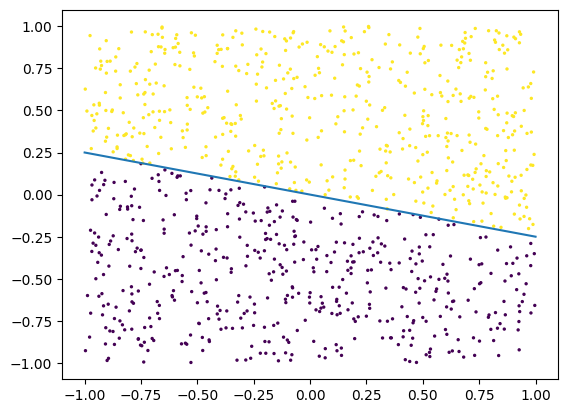

In [4]:
plt.scatter(X[:,0], X[:,1], c=y_binary, s=2)
plt.plot(np.linspace(-1, 1, 1000), -0.5/2*np.linspace(-1, 1, 1000))
plt.show()

In [5]:
# для задачи многоклассовой классификации
labels = np.where(
    X[:, 0] > X[:, 1], 0, 
    np.where(
        (X[:, 0] < X[:, 1]) & (-X[:, 0] > X[:, 1]), 
        1, 
        2
    )
)

y_multiclass = np.zeros((labels.size, labels.max() + 1))
y_multiclass[np.arange(labels.size), labels] = 1

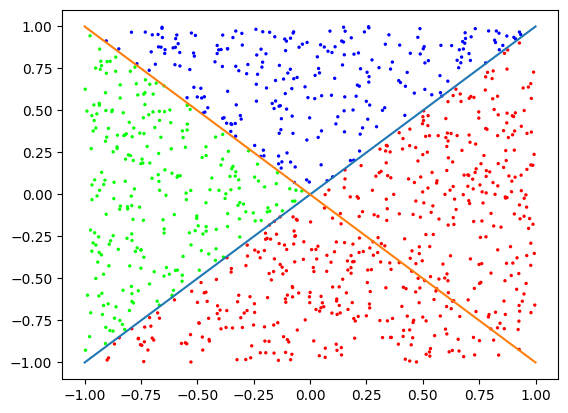

In [17]:
plt.scatter(X[:,0], X[:,1], c=y_multiclass, s=2)
plt.plot(np.linspace(-1, 1, 1000), np.linspace(-1,1,1000))
plt.plot(np.linspace(-1, 1, 1000), -np.linspace(-1,1,1000))
plt.show()

In [13]:
gdc_binary = GradientBoostingClassifier(loss="log_loss", max_depth=5)

In [14]:
gdc_binary.fit(X, y_binary)

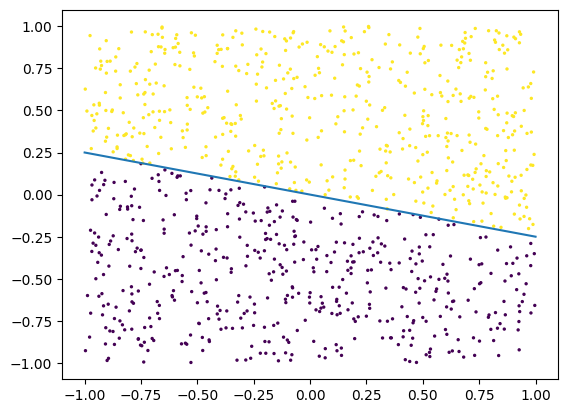

In [15]:
plt.scatter(X[:,0], X[:,1], c=gdc_binary.predict(X), s=2)
plt.plot(np.linspace(-1, 1, 1000), -0.5/2*np.linspace(-1, 1, 1000))
plt.show()

In [10]:
gdc_multiclass = GradientBoostingClassifier(loss="cross_entropy", max_depth=20)

In [11]:
gdc_multiclass.fit(X, y_multiclass)

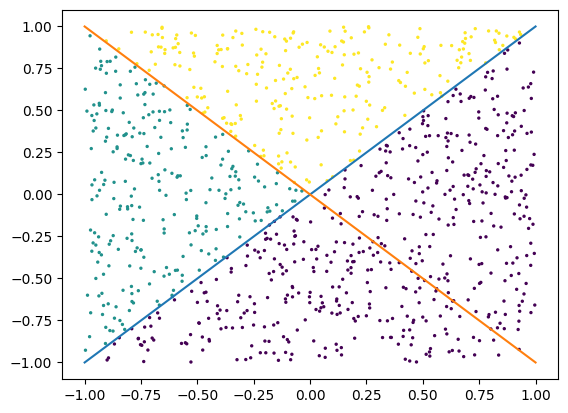

In [16]:
plt.scatter(X[:,0], X[:,1], c=gdc_multiclass.predict(X), s=2)
plt.plot(np.linspace(-1, 1, 1000), np.linspace(-1,1,1000))
plt.plot(np.linspace(-1, 1, 1000), -np.linspace(-1,1,1000))
plt.show()